<a href="https://colab.research.google.com/github/tomonari-masada/course2022-stats2/blob/main/04_examples_(in_class).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. モデリングの例
* 事前分布の決め方が分析結果にどう影響するかを見る。

## 4.1 準備

In [ ]:
!pip install arviz
!pip install pymc3

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc3 as pm

warnings.simplefilter(action="ignore", category=FutureWarning)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

SEED = 1234

## 4.2 Rosenthal and Jacobson (1968) の実験の結果を分析する
* 「統計モデリング1」で紹介だけした。
 * https://github.com/tomonari-masada/course-stats1/blob/master/06_normal_2.pdf
* データは原論文のものではなく、それに似せて作ったもの。
 * [STA 360/602: Bayesian Methods and Modern Statistics @ Duke University](http://www2.stat.duke.edu/~rcs46/bayes17.html)のModule 4より拝借。
* 明らかにしたいこと： 教師が期待をかけるか否かで学生の学修に影響があるか？
 * つまり、$P(\mu_s > \mu_c | \mathbf{x}_s, \mathbf{x}_c)$を知りたい。
 * $\mathbf{x}_s$: spurters（期待をかけられた学生たち）のIQ変化量データ群
 * $\mathbf{x}_c$: controls（その他の学生たち）のIQ変化量データ群


### 4.2.1 データ
* 数値は、実験開始直前からのIQの変化量を表す。
 * このデータは、原論文のものではなく、上掲の講義資料から取ったもの。

In [2]:
x_s = [18, 40, 15, 17, 20, 44, 38]
x_c = [-4, 0, -19, 24, 19, 10, 5, 10,
       29, 13, -9, -8, 20, -1, 12, 21,
       -7, 14, 13, 20, 11, 16, 15, 27,
       23, 36, -33, 34, 13, 11, -19, 21,
       6, 25, 30,22, -28, 15, 26, -1, -2,
       43, 23, 22, 25, 16, 10, 29]

* ヒストグラムを描いてみる。

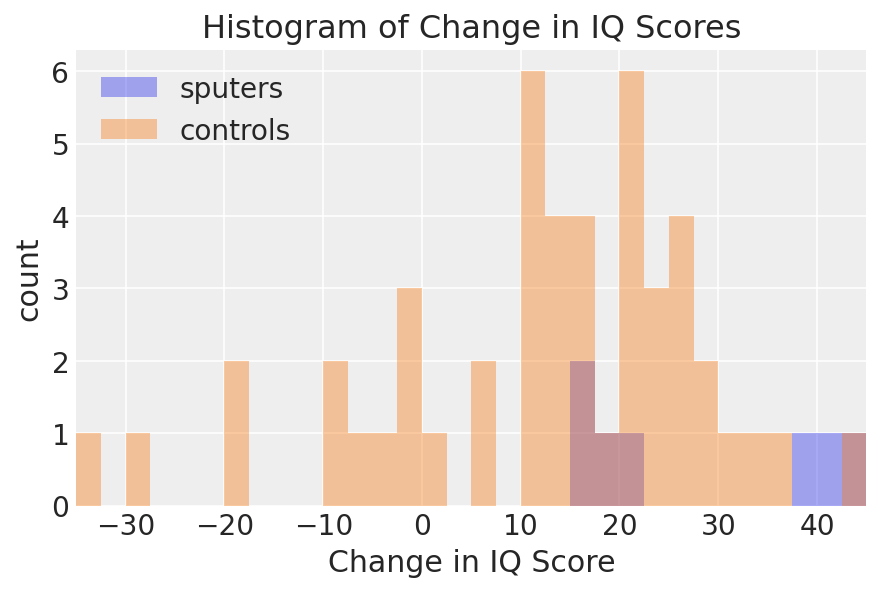

In [3]:
sns.distplot(x_s, kde=False, bins=np.linspace(-35, 45, 33), label="sputers")
sns.distplot(x_c, kde=False, bins=np.linspace(-35, 45, 33), label="controls")
plt.xlim(-35, 45)
plt.xlabel('Change in IQ Score')
plt.ylabel('count')
plt.title('Histogram of Change in IQ Scores')
plt.legend();

### 4.2.2 モデル
* 各グループの変化量は異なる正規分布に従うと仮定する。
 * spurtersの変化量のモデル $x_s \sim N(\mu_s, \lambda_s^{-1})$
 * controlsの変化量のモデル $x_c \sim N(\mu_c, \lambda_c^{-1})$
* 各グループの正規分布の平均パラメータは、同じ正規分布に従うと仮定する。
 * つまり $\mu_s, \mu_c \sim N(\mu_0, \sigma_0^2)$
* 各グループの正規分布の精度（分散の逆数）パラメータは、同じガンマ分布に従うと仮定する。
 * つまり $\lambda_s, \lambda_c \sim \text{Gam}(\alpha, \beta)$
* $N(\mu_0, \sigma_0^2)$と$\text{Gam}(\alpha, \beta)$が、事前分布。

### 4.2.3 ハイパーパラメータの決め方
* 事前分布のパラメータをハイパーパラメータと呼ぶ。


* 精度パラメータが従うガンマ分布$\text{Gam}(\alpha, \beta)$については、[STA 360/602: Bayesian Methods and Modern Statistics @ Duke University](http://www2.stat.duke.edu/~rcs46/bayes17.html)のModule 4の決め方を踏襲する。
 * $\alpha$は$\frac{1}{2}$とする。
 * $\beta$は$10^2\alpha$とする。
* この設定は、以下の議論で固定しておく。

### 4.2.4 問題
* $\text{Gam}(\alpha, \beta)$のパラメータを上のように決めると、IQ変化量の分散ついて、どのように仮定していることになるか？
 * ヒント1： $\text{Gam}(\alpha, \beta)$がモデリングしているのは、精度、つまり、分散の逆数であることに注意しよう。
 * ヒント2： $\text{Gam}(\alpha, \beta)$に従う確率変数の値の平均は、$\frac{\alpha}{\beta}$である。

## 4.3 事前分布 (1)
* 平均パラメータが従う正規分布$\mu \sim N(\mu_0, \sigma_0^2)$について、まずは以下のように設定してみる。
 * 別の設定については、後で議論する。



### 4.3.1 事前分布の平均パラメータ$\mu_0$の設定
* 平均パラメータ$\mu_0$は0とする。
 * なぜなら、IQの変化量の平均が、増えるのか、減るのか、全く分からないから。

### 4.3.2 事前分布の分散パラメータ$\sigma_0^2$の設定
* 標準偏差パラメータ$\sigma_0$は1とする。
 * これは、ざっくり言うと、どういうお気持ちを表しているか？


* 考察をしやすくするために、観測データが従う正規分布$N(\mu, \sigma^2)$の分散$\sigma^2$を固定する。
* すると、$\mu$の事後分布の分散は$(\frac{1}{\sigma_0^2} + \frac{n}{\sigma^2})^{-1}$となる。
 * $n$は観測データの個数。
* $\sigma_0$を大きくすると、$n$個の観測データで決まる$\frac{n}{\sigma^2}$の項のほうが支配的となる。
* $\sigma_0$を小さくすると、$\frac{1}{\sigma_0^2}$の項のほうが支配的となる。
* $\sigma_0=1$という仮定は、ざっくり言って、これらの中間。
* つまり、IQ変化量の平均$\mu$がどのくらいバラつくかという不確かさについて、（非常にざっくり言って）事前分布が観測データ一個分と同程度の寄与をする、と仮定している。
 * 観測データ0個分でもなく、全観測データ以上分でもない、ということ。

### 4.3.3 PyMC3によるモデルの実装

In [4]:
mu_0 = 0.0
sd_0 = 1.0
alpha = 0.5

model = pm.Model()

with model:
  lambda_s = pm.Gamma("lambda_s", alpha=alpha, beta=100*alpha)
  lambda_c = pm.Gamma("lambda_c", alpha=alpha, beta=100*alpha)
  mu_s = pm.Normal("mu_s", mu=mu_0, sigma=sd_0)
  mu_c = pm.Normal("mu_c", mu=mu_0, sigma=sd_0)
  obs_s = pm.Normal("obs_s", mu=mu_s, tau=lambda_s, observed=np.array(x_s))
  obs_c = pm.Normal("obs_c", mu=mu_c, tau=lambda_c, observed=np.array(x_c))

### 4.3.4 MCMC
* デフォルトのNUTSサンプラを使う。

In [5]:
with model:
  trace = pm.sample(2000, cores=4, return_inferencedata=True, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_c, mu_s, lambda_c, lambda_s]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.


### 4.3.5 サンプルのチェック

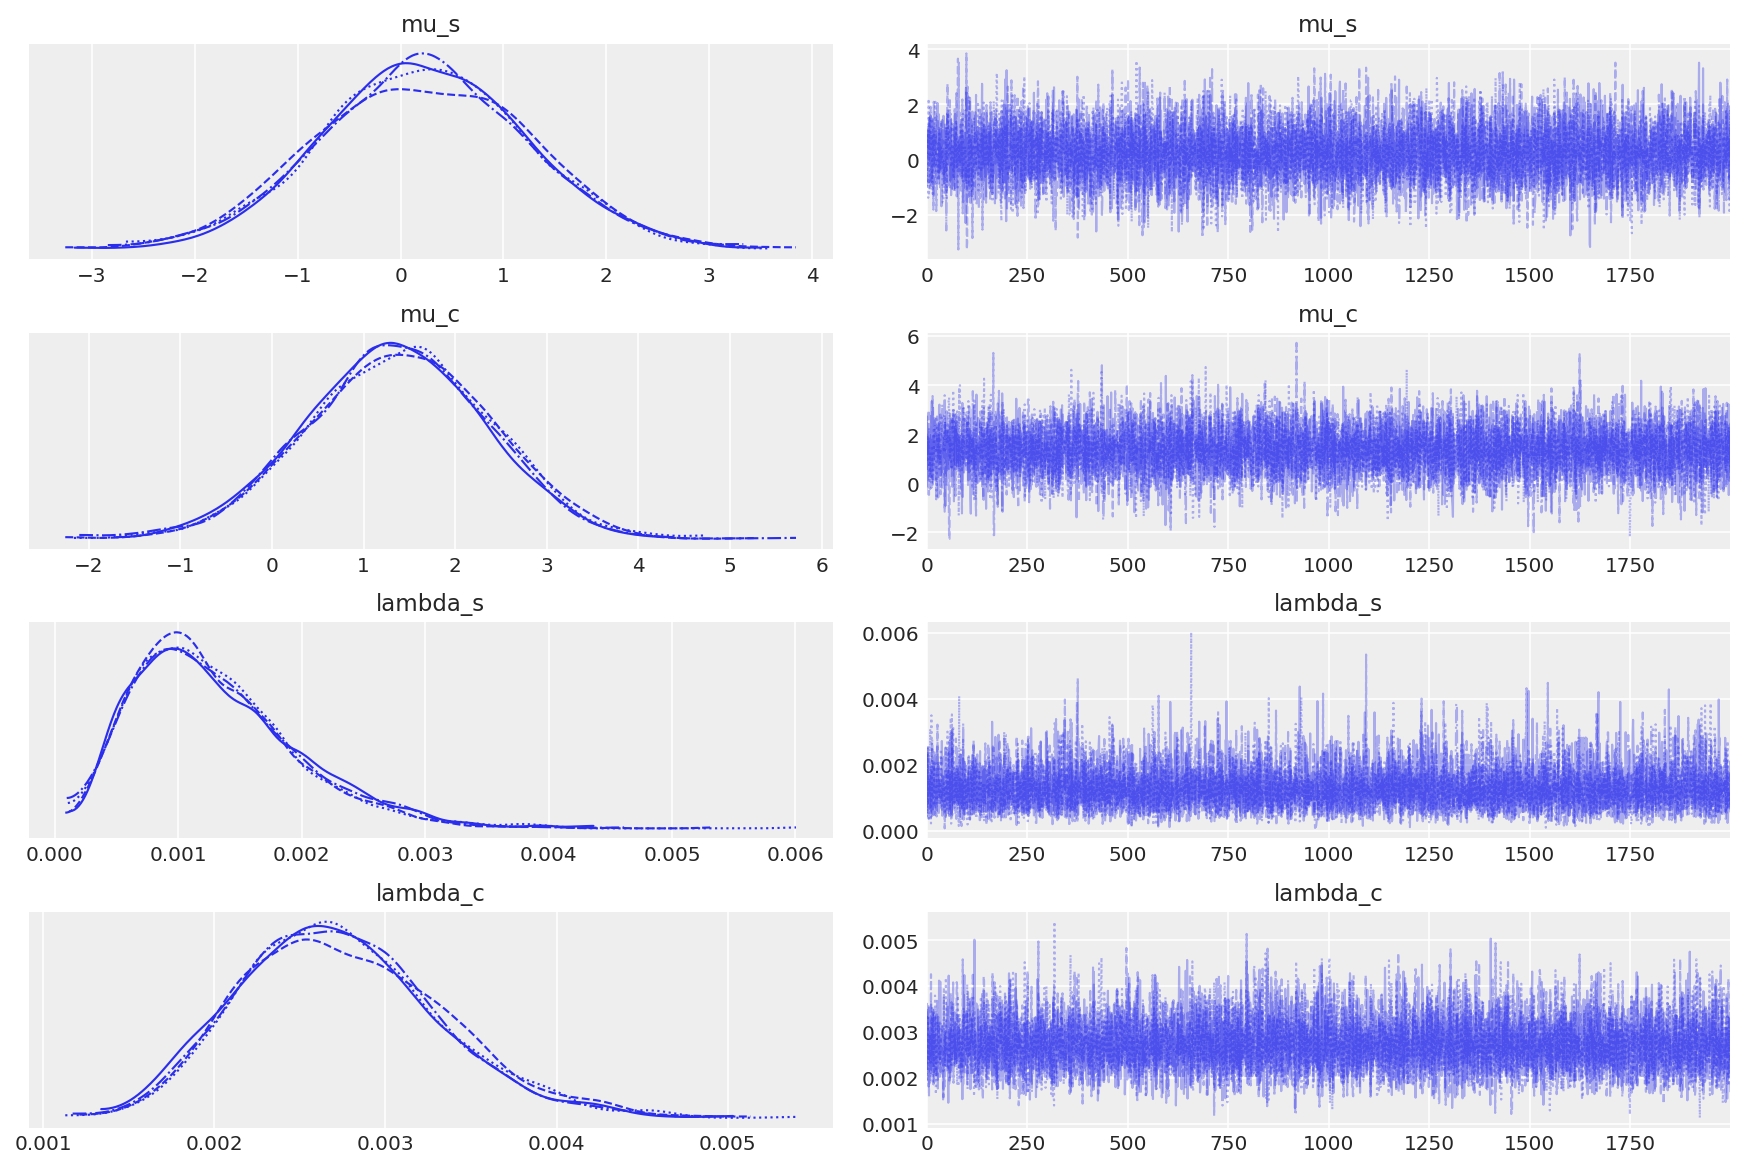

In [6]:
az.plot_trace(trace);

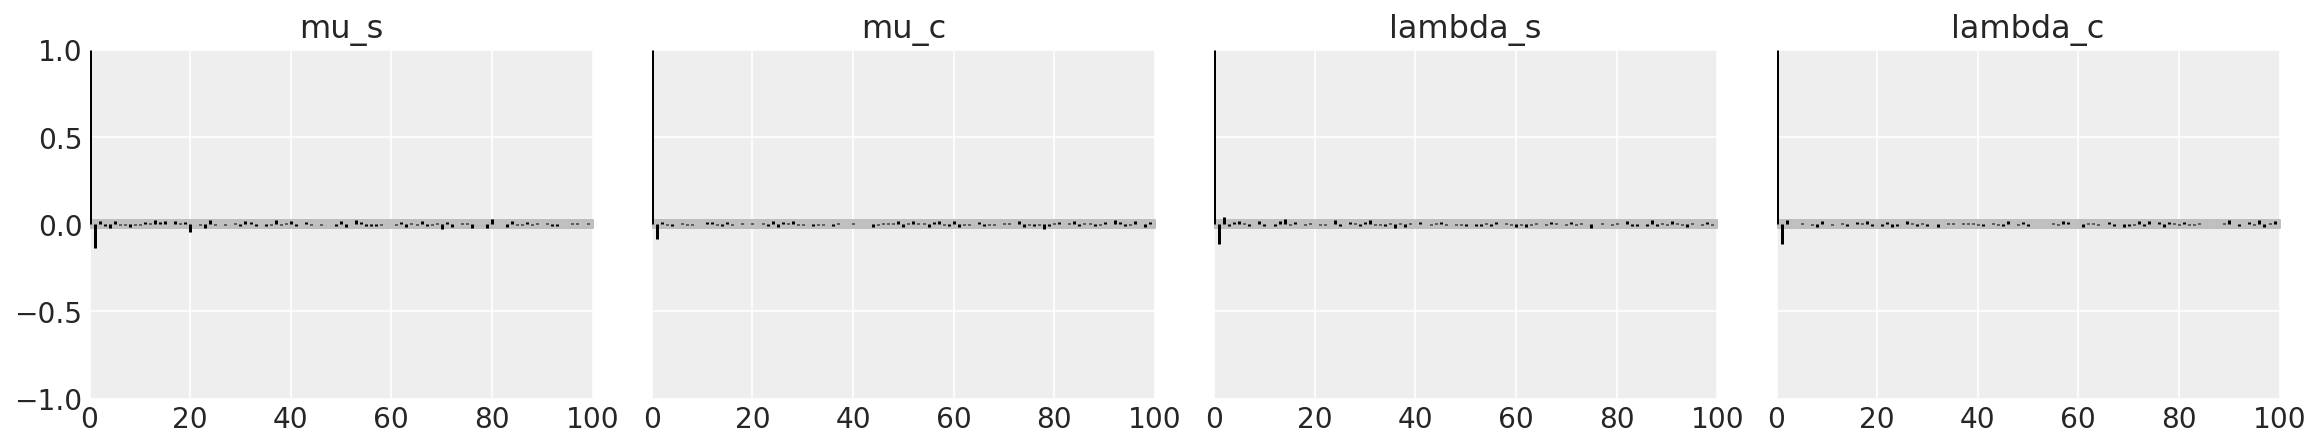

In [7]:
az.plot_autocorr(trace, combined=True, figsize=(16,3));

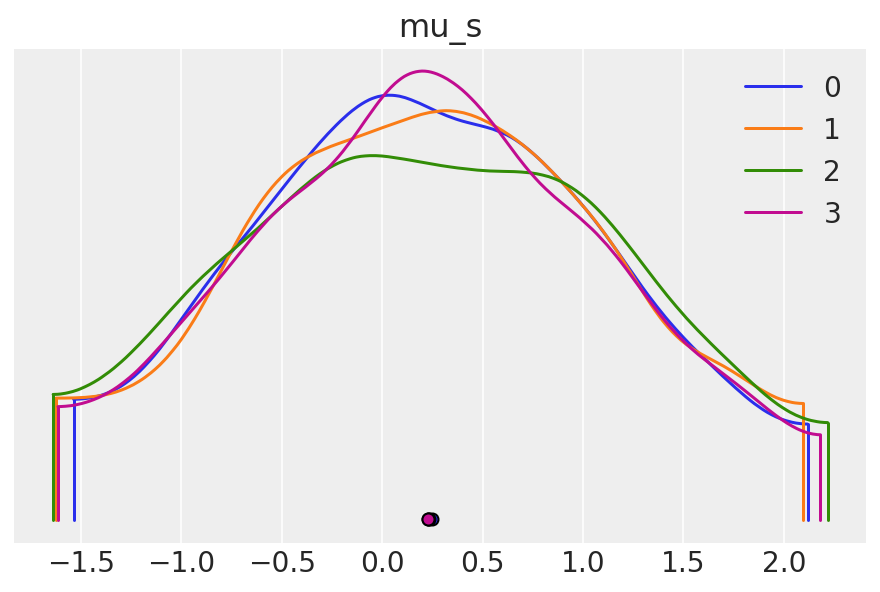

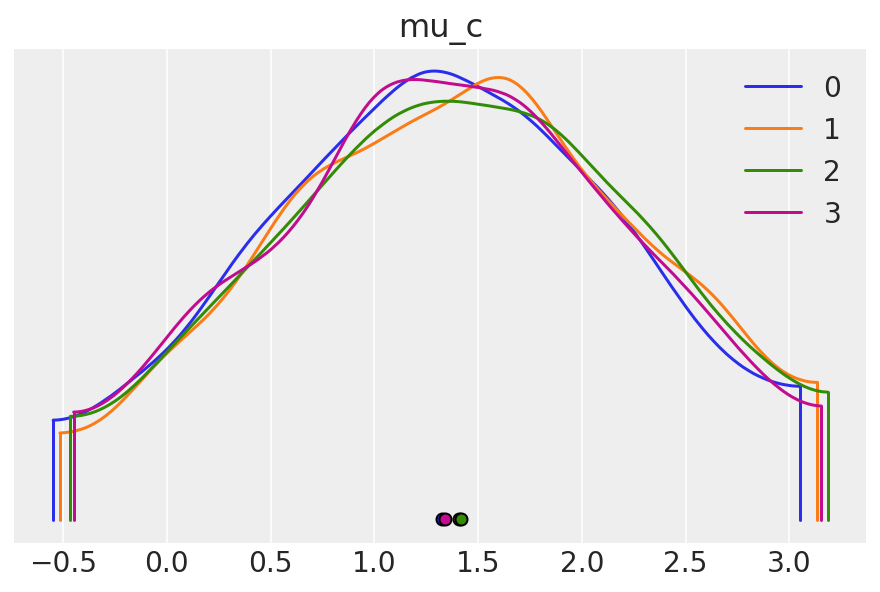

In [8]:
az.plot_density([c for c in trace.posterior.mu_s])
az.plot_density([c for c in trace.posterior.mu_c]);

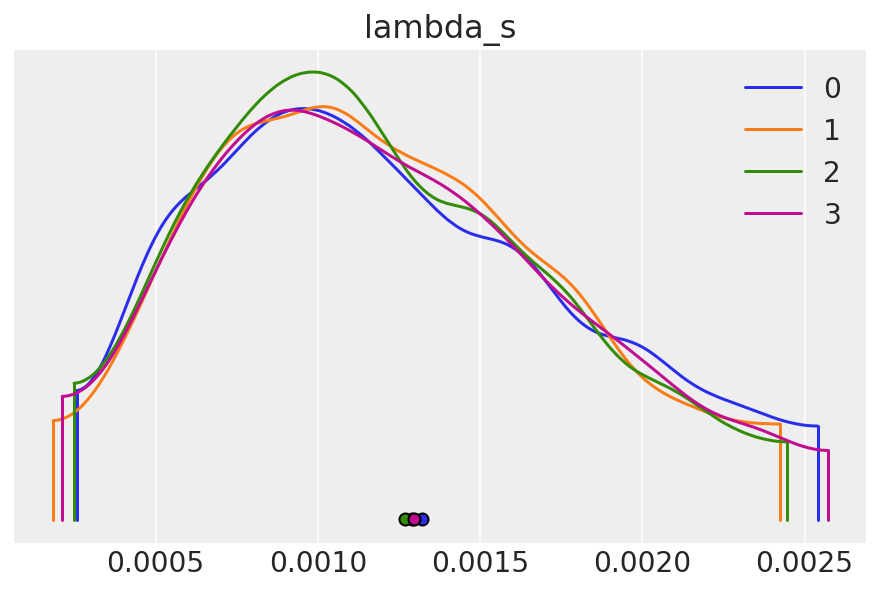

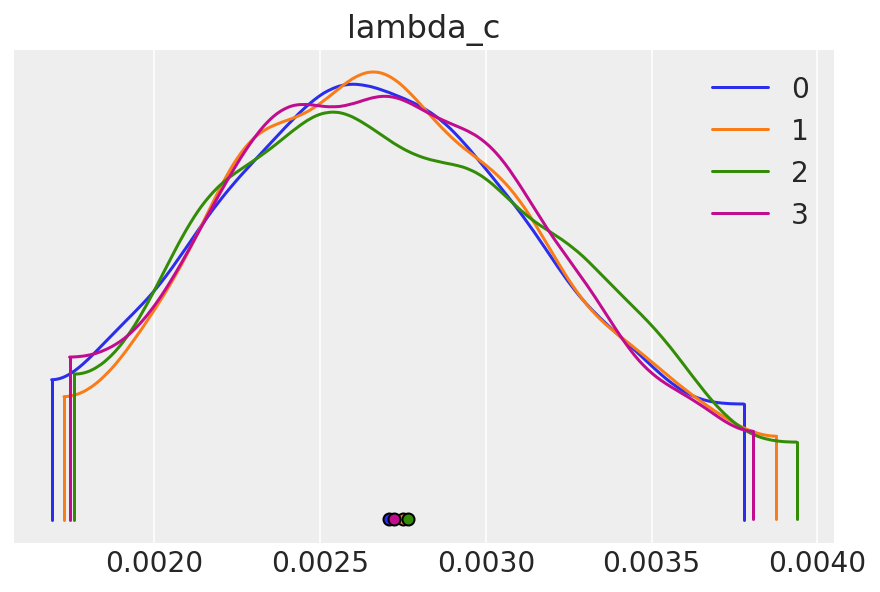

In [9]:
az.plot_density([c for c in trace.posterior.lambda_s])
az.plot_density([c for c in trace.posterior.lambda_c]);

In [10]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_s,0.234,1.013,-1.593,2.188,0.01,0.011,10840.0,6096.0,1.0
mu_c,1.372,0.982,-0.482,3.160,0.01,0.008,9460.0,6174.0,1.0
lambda_s,0.001,0.001,0.000,0.002,0.00,0.000,9331.0,5850.0,1.0
lambda_c,0.003,0.001,0.002,0.004,0.00,0.000,9621.0,6111.0,1.0


In [11]:
(trace.posterior.mu_s > trace.posterior.mu_c).sum() / 8000

<xarray.DataArray ()>
array(0.209625)

* $\mu_s > \mu_c$の確率が0.21前後
 * 学生に期待をかけないほうがいい？

## 4.4 事前分布 (2)
* ハイパーパラメータの決め方を考え直す。

### 4.4.1 事前分布の平均パラメータ$\mu_0$の設定
* 平均パラメータ$\mu_0$は、観測データの平均値とする。
 * なぜなら、一定期間教育を受ければ、そもそもIQは増えるものであるから。
 * この意味で、$\mu_0 = 0$という設定は、変だった。
 * しかし、どのくらい増えるものかについて、観測データ以外に手がかりがない。
 * そのため、観測データの単純平均を使うことにする。

In [12]:
np.array(x_s + x_c).mean()

14.0

### 4.4.2 事前分布の分散パラメータ$\sigma_0^2$の設定
* 標準偏差パラメータ$\sigma_0$は100ぐらいとする。
 * つまり、IQ変化量の平均がどのくらいバラつくかという不確かさについては、観測データに決めてもらう、ということ。

### 4.4.3 PyMC3によるモデルの実装

In [13]:
mu_0 = 14.0 # 上で計算した値
sd_0 = 100.0
alpha = 0.5

model = pm.Model()

with model:
  lambda_s = pm.Gamma("lambda_s", alpha=alpha, beta=100*alpha)
  lambda_c = pm.Gamma("lambda_c", alpha=alpha, beta=100*alpha)
  mu_s = pm.Normal("mu_s", mu=mu_0, sigma=sd_0)
  mu_c = pm.Normal("mu_c", mu=mu_0, sigma=sd_0)
  obs_s = pm.Normal("obs_s", mu=mu_s, tau=lambda_s, observed=np.array(x_s))
  obs_c = pm.Normal("obs_c", mu=mu_c, tau=lambda_c, observed=np.array(x_c))

### 4.4.4 MCMC
* デフォルトのNUTSサンプラを使う。

In [14]:
with model:
  trace = pm.sample(2000, cores=4, return_inferencedata=True, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_c, mu_s, lambda_c, lambda_s]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.


### 4.4.5 サンプルのチェック

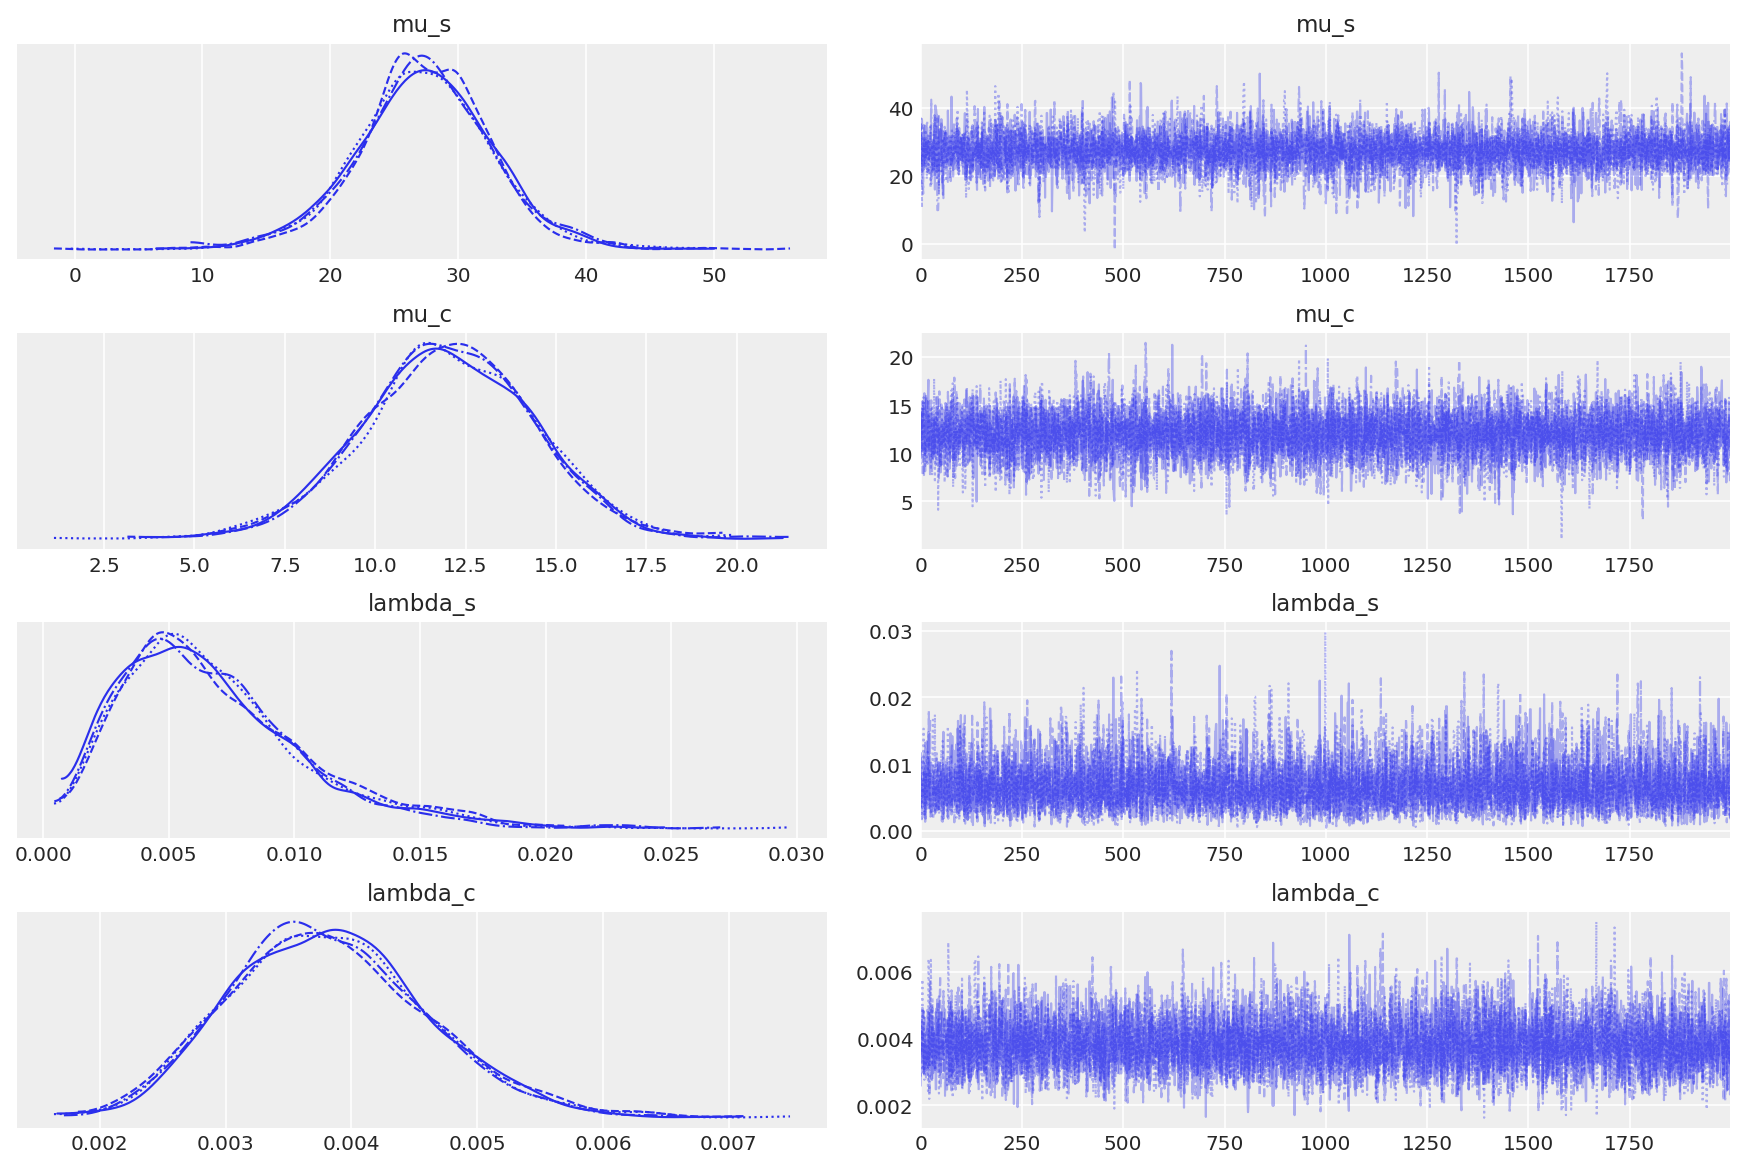

In [15]:
az.plot_trace(trace);

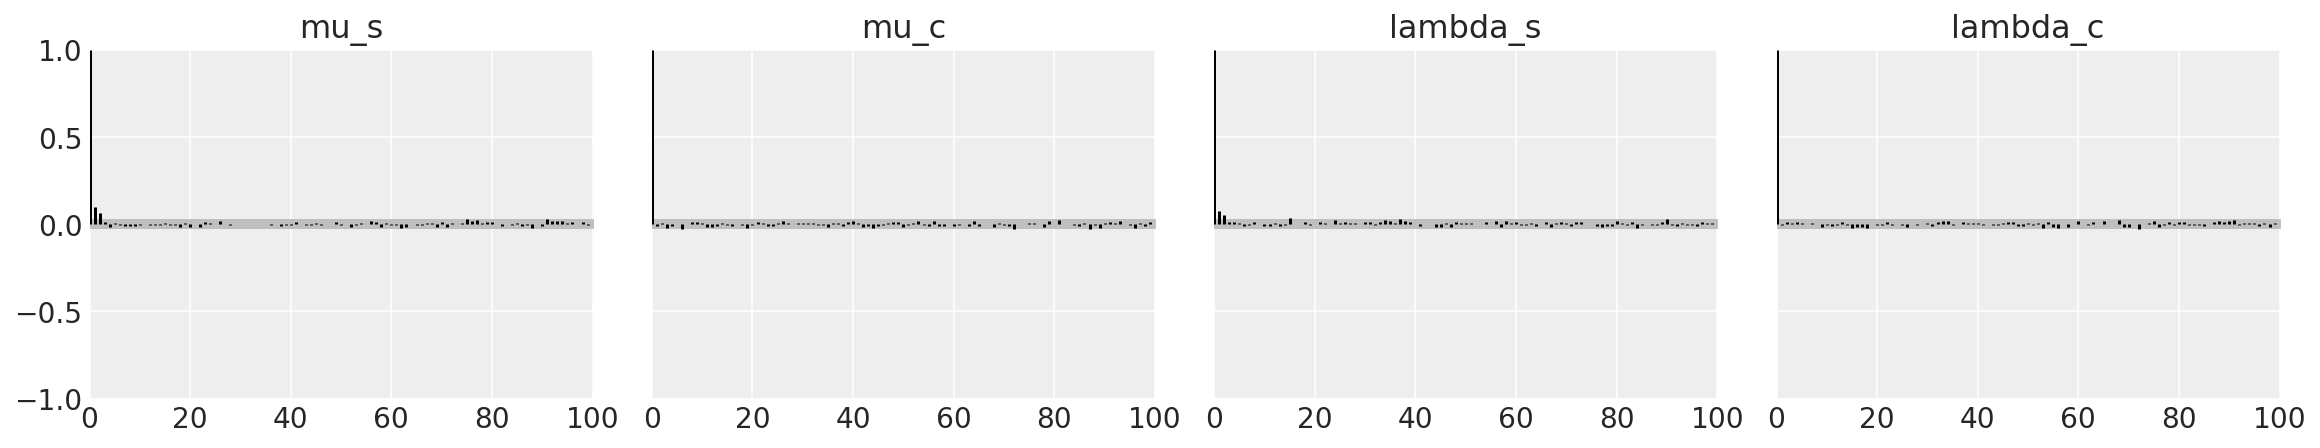

In [16]:
az.plot_autocorr(trace, combined=True, figsize=(16,3));

In [17]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_s,27.330,5.351,16.745,37.333,0.069,0.049,6238.0,4882.0,1.0
mu_c,12.034,2.355,7.554,16.333,0.026,0.019,8126.0,5819.0,1.0
lambda_s,0.007,0.004,0.001,0.014,0.000,0.000,6013.0,4930.0,1.0
lambda_c,0.004,0.001,0.002,0.005,0.000,0.000,7414.0,5631.0,1.0


In [18]:
(trace.posterior.mu_s > trace.posterior.mu_c).sum() / 8000

<xarray.DataArray ()>
array(0.993)

* 先ほどと真逆の結果。

# 課題
* あなたなら、どのように事前分布を決めるか？
* その決め方にしたがって分析をおこない、$P(\mu_s > \mu_c | \mathbf{x}_s, \mathbf{x}_c)$を、上と同様にして求めよう。
* もし、思いつかなければ、単に上の分析をサンプルの個数やchainの数を変えたりして再現してみよう。